# Effects of dropout on propagation speed of synfire chains and their recurrent variants

The aim of this notebook is to investigate how physical perturbations to HVC might affect its dynamics.

## Network Architecture
Conductance-based LIF network. Single-neuron voltage dynamics:

$$C_m \frac{dV}{dt} = g_l[E_l - V(t)] + g_e(t)[E_e - V(t)] + g_i(t)[E_i - V(t)] + I_{ext}(t)$$

The time-varying conductances $g_e(t)$ and $g_i(t)$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$, respectively (convention: weight to $i$ from $j$):

$$\tau_e\frac{dg^i_e}{dt} = -g^i_e + \sum_j W_e^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

$$\tau_i\frac{dg^i_i}{dt} = -g^i_i + \sum_j W_i^{ij} \sum_{t_k^j} \delta(t - t_k^j)$$

where $t_k^j$ are the spike times in the $j$-th neuron.

### Chain structure and connectivity

The 'modified' synfire chain is constructed as follows: we first define a chainlink as a collection of neurons with random, recurrent, excitatory connections. The number of afferents each neuron receives is normalized (specifically, we specify the percentage of the total number of neurons within the chainlink from which each neuron receives afferents).

Chainlinks are then ordered, and each neuron in chainlink i+1 receives excitatory connections from each neuron
in chainlink i.

# Code
### Define reversal potentials, conductance decay timescales, network properties, and other constants

In [155]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w
from utils.general import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=2e-3,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, T_E=.002, T_I=.002,

    # NTWK ARCHITECTURE
    N_NUCLEI=4, # number of nuclei
    N_E_NUCLEUS=1000, # number of excitatory neurons on one nucleus
    N_I_NUCLEUS=250, # number of inhibitory neurons on one nucleus
    N_LOOPS=25, # number of loops through all 4 nuclei
    F_GROUP=[0.0273, 0.0273, 0.0273, 0.0273], # F_GROUP * N_E_NUCLEUS = number of neurons representing a time point in one group
    W_E_E_F=0.180e-3,  # E-E feed-forward cxns from one nucleus to the next
    W_E_E_R=0.005e-3,  # E-E recurrent cxns within nucleus
    W_E_I_R=0.005e-3, # E-I recurrent cxns within nucleus
    W_I_E_R=0.005e-3, # I-E recurrent cxns within nucleus
    W_U_E=0.0008, # excitatory input weights
    HVC_I_E_CNXN_PROB=0.7, # probability of inh --> exc connection in HVC
    HVC_E_I_CNXN_PROB=0.7, # probability of exc --> inh connection in HVC
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

def set_dynamic_vars(m):
    m.nucleus_size = m.N_E_NUCLEUS + m.N_I_NUCLEUS
    m.total_circuit_size = m.nucleus_size * m.N_NUCLEI
    
set_dynamic_vars(M)

## SMLN
S = Generic(RNG_SEED=0, DT=.0005)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

T_M_E = 10.0 ms


# Single neuron EPSPs and IPSPs

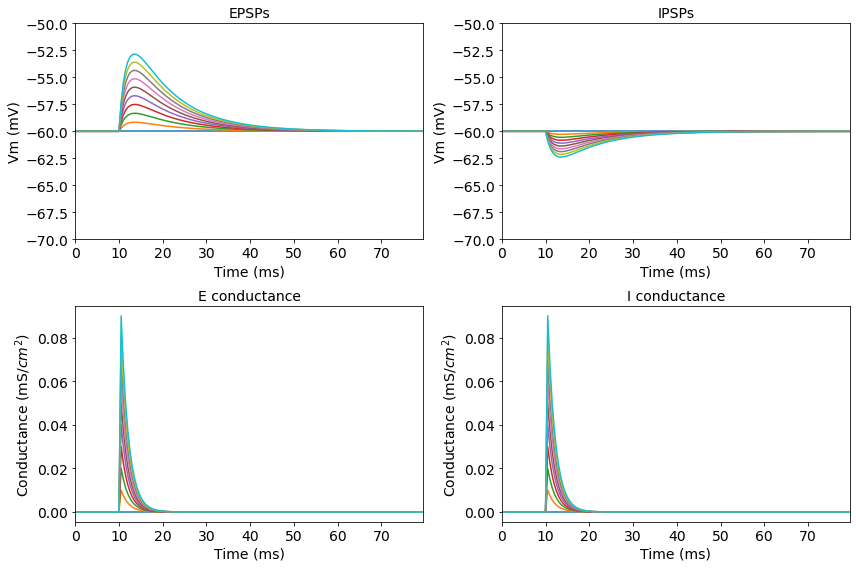

In [156]:
np.random.seed(0)
# EPSP size vs E weight
t = np.arange(0, .08, S.DT)
rsps_e = []

for w_u_e_e in np.arange(10) * 0.01e-3:
    w_u_e_i = 0

    ntwk = LIFNtwkG(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=M.V_TH_E,
        v_r=M.E_L_E,
        t_r=np.inf,
        e_s={'E': M.E_E, 'I': M.E_I},
        t_s={'E': M.T_E, 'I': M.T_I},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])})
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S.DT)), 0] = 1
    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: np.array([M.E_L_E])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_e.append(copy(rsp))
    

# IPSP size vs I weight
rsps_i = []

for w_u_e_i in np.arange(10) * 0.01e-3:
    w_u_e_e = 0

    ntwk = LIFNtwkG(
        c_m=M.C_M_E,
        g_l=M.G_L_E,
        e_l=M.E_L_E,
        v_th=M.V_TH_E,
        v_r=M.E_L_E,
        t_r=np.inf,
        e_s={'E': M.E_E, 'I': M.E_I},
        t_s={'E': M.T_E, 'I': M.T_E},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])})
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S.DT)), 1] = 1
    rsp = ntwk.run(
        dt=S.DT,
        clamp=Generic(v={0: np.array([M.E_L_E])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_i.append(copy(rsp))

    
# plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
for rsp_e in rsps_e:
    axs[0, 0].plot(1000*t, 1000*rsp_e.vs[:, 0])
    axs[1, 0].plot(1000*t, 1000*rsp_e.gs['E'][:, 0])
for rsp_i in rsps_i:
    axs[0, 1].plot(1000*t, 1000*rsp_i.vs[:, 0])
    axs[1, 1].plot(1000*t, 1000*rsp_i.gs['I'][:, 0])
    
for ax in axs[0, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_ylim(-70, -50)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Vm (mV)')
    
for ax in axs[1, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Conductance (mS/$cm^2$)')
    
axs[0, 0].set_title('EPSPs')
axs[0, 1].set_title('IPSPs')

axs[1, 0].set_title('E conductance')
axs[1, 1].set_title('I conductance')
    
for ax in axs.flatten():
    set_font_size(ax, 14)

In [157]:
def bin_occurrences(occurrences, min_idx=0, max_idx=None, bin_size=1):
    if max_idx is None:
        max_idx = occurrences.max() + 1
    binned = np.zeros(max_idx - min_idx)
    for n in occurrences:
        if n >= max_idx or n < min_idx:
            raise IndexError(f'index {n} is out of bounds for min {min_idx} and max {max_idx}')
        binned[n - min_idx] += 1
    return binned

def calc_degree_dist(mat):
    degree_freqs = bin_occurrences(np.count_nonzero(mat, axis=1))
    return np.arange(len(degree_freqs)), degree_freqs

# Full chain

### Helper functions for defining network connectivity

In [170]:
def rand_n_ones_in_vec_len_l(n, l):
    if n > l:
        raise ValueError('n cannot be greater than l')
    vec = np.concatenate([np.ones(n, int), np.zeros(l - n, int)])
    return vec[np.random.permutation(l)]

#     # NTWK ARCHITECTURE
#     N_NUCLEI=4, # number of nuclei
#     N_E_NUCLEUS=1000, # number of excitatory neurons on one nucleus
#     N_I_NUCLEUS=250, # number of inhibitory neurons on one nucleus
#     N_LOOPS=25, # number of loops through all 4 nuclei
#     F_GROUP=0.0273, # F_GROUP * N_E_NUCLEUS = number of neurons representing a time point in one group
#     W_E_E_F=0.01e-3,  # E-E feed-forward cxns from one nucleus to the next
#     W_E_E_R=0.005e-3,  # E-E recurrent cxns within nucleus
#     W_E_I_R=0.005e-3, # E-I recurrent cxns within nucleus
#     W_I_E_R=0.005e-3, # I-E recurrent cxns within nucleus
#     W_U_E=0.01, # excitatory input weights

def make_proj(m, w_mat, receiving_indices, projecting_indices):
    for r_idx in receiving_indices:
        for p_idx in projecting_indices:
            w_mat[r_idx, p_idx] = (m.W_E_E_F / projecting_indices.shape[0])

def make_ff_structure(m):
    nucleus_size = m.N_E_NUCLEUS + m.N_I_NUCLEUS
    timepoint_groups = []
    
    for i_l in range(m.N_LOOPS):
        for i_n in range(m.N_NUCLEI):
            n_timepoint_neurons_in_nucleus = int(m.F_GROUP[i_n] * m.N_E_NUCLEUS)
            timepoint_group = np.random.choice(np.arange(m.N_E_NUCLEUS), size=n_timepoint_neurons_in_nucleus, replace=False)
            timepoint_group += i_n * nucleus_size
            timepoint_groups.append(timepoint_group)
    
    total_circuit_size = m.N_NUCLEI * nucleus_size
    w_mat = np.zeros((total_circuit_size, total_circuit_size))
    
    for i in range(len(timepoint_groups) - 1):
        make_proj(m, w_mat, timepoint_groups[i+1], timepoint_groups[i])
        
    return w_mat, timepoint_groups

def gen_timepoint_groups_for_nucleus(m, timepoint_groups, nucleus_idx):
    return [timepoint_groups[i + nucleus_idx] for i in range(0, len(timepoint_groups), m.N_NUCLEI)]

def make_i_e_structure(m, timepoint_groups, nucleus_idx):
    timepoint_groups_for_nucleus = gen_timepoint_groups_for_nucleus(m, timepoint_groups, nucleus_idx)
    
    num_timepoints = len(timepoint_groups)
    num_i_connections_to_e_groups = int(m.HVC_I_E_CNXN_PROB * num_timepoints)
    i_to_timepoint_e_map = []
    
    for inh_idx in range(m.N_I_NUCLEUS):
        inh_map = np.random.choice(np.arange(num_timepoints), num_i_connections_to_e_groups, replace=False)
        i_to_timepoint_e_map.append(inh_map)
        
    w_r_i_base = np.zeros((m.total_circuit_size, m.total_circuit_size))

### Define function for simulating a single set of parameters using three different input UVA frequences

In [159]:
def run_test(m, show_connectivity=False, repeats=1, n_show_only=None, add_noise=True):

    w_r_e, timepoint_groups = make_ff_structure(m)
    
    w_u_input_base = np.zeros((m.N_E_NUCLEUS, m.N_E_NUCLEUS))
    
    for cell_idx in timepoint_groups[0]:
        w_u_input_base[cell_idx, cell_idx] = m.W_U_E
    
    ## input weights
    w_u = {
        # localized inputs to trigger activation from start of chain
        'E': np.block([
            [ w_u_input_base, np.zeros([m.N_E_NUCLEUS, m.total_circuit_size]) ],
            [ np.zeros([m.total_circuit_size - m.N_E_NUCLEUS, m.total_circuit_size + m.N_E_NUCLEUS]) ],
        ]),

        # global inhibitory inputs across chain
        'I': np.zeros((m.total_circuit_size, m.N_E_NUCLEUS + m.total_circuit_size))
    }
    
    ## recurrent weights
    w_r = {
        'E': w_r_e,
        'I': np.zeros((m.total_circuit_size, m.total_circuit_size)),
    }
    
    # generate timesteps and initial excitatory input window
    t = np.arange(0, S.T, S.DT)
    t_u = [.01, .011]
    t_mask = (t_u[0] <= t) & (t < t_u[1])
    
    all_rsps = []

    # run simulation for same set of parameters
    for rp_idx in range(repeats):
        show_trial = (type(n_show_only) is int and rp_idx < n_show_only)

        rsps_for_trial = []

        ## external currents
        if add_noise:
            i_ext = m.SGM_N/S.DT * np.random.randn(len(t), m.total_circuit_size) + m.I_EXT_B
        else:
            i_ext = m.I_EXT_B * np.ones((len(t), m.total_circuit_size))

        ## inp spks
        spks_u_base = np.zeros((len(t), m.N_E_NUCLEUS + m.total_circuit_size), dtype=int)

        # trigger inputs
        tmp = cc([np.ones(m.N_E_NUCLEUS, int), np.zeros(m.N_E_NUCLEUS*(t_mask.sum()-1))])
        spks_u_base[t_mask, :m.N_E_NUCLEUS] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m.N_E_NUCLEUS)
            
        if show_trial:
            # gen_degree_dist_graphs(w_r, m)
            # show_afferent_stats(w_r, m)
            pass

        if show_connectivity:
            fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)
            axs[0, 0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
            axs[0, 0].set_title('W_R[E]\n')
            axs[0, 1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
            axs[0, 1].set_title('W_R[I]\n')

            axs[1, 0].matshow(w_u['E'], vmin=0, vmax=10e-6, cmap='binary')
            axs[1, 0].set_title('W_U[E]\n')
            axs[1, 0].set_xlim(0, m.N_E_NUCLEUS)
            axs[1, 0].set_ylim(m.N_E_NUCLEUS, 0)
            
            axs[1, 1].spy(w_u['I'], markersize=1)
            axs[1, 1].set_title('W_U[I]\n')

            for ax in axs.flatten():
                set_font_size(ax, 14)

        ntwk = LIFNtwkG(
            c_m=m.C_M_E,
            g_l=m.G_L_E,
            e_l=m.E_L_E,
            v_th=m.V_TH_E,
            v_r=m.E_L_E,
            t_r=m.T_R_E,
            e_s={'E': M.E_E, 'I': M.E_I},
            t_s={'E': M.T_E, 'I': M.T_E},
            w_r=w_r,
            w_u=w_u)

        clamp = Generic(
            v={0: np.repeat(m.E_L_E, m.total_circuit_size)}, spk={})

        spks_u = spks_u_base.copy()
#             spks_u[:, -(m.N_P_I):] = np.random.poisson(fq_spk_u_i * S.DT, (len(t), m.N_P_I))

        # run smln
        rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)

        all_rsps.append({
            'spks_t': copy(rsp.spks_t),
            'spks_c': copy(rsp.spks_c),
            'spks_u': spks_u_base.nonzero(),
        })

    return all_rsps, timepoint_groups

In [160]:
def gen_exc_inh_masks(raster, m, timepoint_groups):
    exc_masks = []
    inh_masks = []
    
    for n_idx in range(m.N_NUCLEI):
        nucleus_start = m.nucleus_size * n_idx
        nucleus_end = m.nucleus_size * (n_idx + 1)
        
        exc_masks.append((raster[1, :] >= nucleus_start) & (raster[1, :] < (nucleus_start + m.N_E_NUCLEUS)))
        inh_masks.append((raster[1, :] >= (nucleus_end - m.N_I_NUCLEUS)) & (raster[1, :] < nucleus_end))
    
    logical_or = lambda a, b: a | b
    
    all_exc_mask = reduce(logical_or, exc_masks)
    all_inh_mask = reduce(logical_or, inh_masks)
    
    return (exc_masks, inh_masks, all_exc_mask, all_inh_mask)

In [192]:
def calc_hvc_coherence(m, spks_t, spks_tg):
    tg_raster = np.stack([spks_t, spks_tg])
    hvc_tg_raster = tg_raster[:, (tg_raster[1, :] % 4) != 0]
    hvc_tg_raster[1, :] = hvc_tg_raster[1, :] / 4
    return hvc_tg_raster

In [193]:
def quick_plot(m,
               overlay=False, repeats=1, show_connectivity=True, n_show_only=None, add_noise=True):
    all_rsps, timepoint_groups = run_test(m, show_connectivity=show_connectivity, repeats=repeats,
                        n_show_only=n_show_only, add_noise=add_noise)
    
    nrn_idx_to_tg_group = np.zeros(m.total_circuit_size, dtype=int)
    for tg_idx, timepoint_group in enumerate(timepoint_groups):
        nrn_idx_to_tg_group[timepoint_group] = tg_idx
    
#     mean_spks_dataframe = pd.DataFrame({
#         'trial': [],
#         'mean_spk_times': [],
#     })
    
    colors = ['black', 'blue', 'green', 'purple', 'brown']
    
    def tg_group_to_color(tg_groups):
        output = []
        c_len = len(colors)
        for tgg in tg_groups:
            output.append(colors[int(tgg / m.N_NUCLEI) % c_len])
        return output
        
    for idx_r, rsp in enumerate(all_rsps):
        show_trial = (type(n_show_only) is int and idx_r < n_show_only)

        if overlay and show_trial:
            gs = gridspec.GridSpec(2, 1)
            fig = plt.figure(figsize=(10, 20), tight_layout=True)
            axs = [fig.add_subplot(gs[0:2])] # fig.add_subplot(gs[2]), fig.add_subplot(gs[3]), fig.add_subplot(gs[4])

        raster = np.stack([rsp['spks_t'], rsp['spks_c'], nrn_idx_to_tg_group[rsp['spks_c']]])
        
        (exc_masks, inh_masks, all_exc_mask, all_inh_mask) = gen_exc_inh_masks(raster, m)
    
        exc_raster = raster[:, all_exc_mask]
        inh_raster = raster[:, all_inh_mask]

#         mean_spks_dataframe = mean_spks_dataframe.append(pd.DataFrame({
#             'trial': [idx_r],
#             'dropout_idx': [idx_do],
#             'mean_spk_times': [mean_spk_times],
#         }))

        if show_trial:
            if not overlay:
                gs = gridspec.GridSpec(4, 1)
                fig = plt.figure(figsize=(14, 10), tight_layout=True)
                axs = [fig.add_subplot(gs[0:2]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3])]
            
            c = tg_group_to_color(raster[2, :])
#             print(c)
            axs[0].scatter(exc_raster[0, :] * 1000, exc_raster[1, :], s=1, c=c, zorder=0, alpha=1)
            axs[0].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], s=1, c='red', zorder=0, alpha=1)
            
            axs[0].set_xlabel('Time (ms)')
            axs[0].set_ylim(-1, m.total_circuit_size)
            
            axs[1].scatter(rsp['spks_u'][0] * S.DT * 1000, rsp['spks_u'][1])
            axs[1].set_xlim(0, 100)
            axs[1].set_xlabel('Time (ms)')
            axs[1].set_ylim(-1, m.N_E_NUCLEUS)
            axs[1].set_ylabel('Cell Index')
            
            hvc_tg_raster = calc_hvc_coherence(m, rsp['spks_t'], nrn_idx_to_tg_group[rsp['spks_c']])
            
            axs[2].scatter(hvc_tg_raster[0, :] * 1000, hvc_tg_raster[1, :], s=1, c='black')

            for i in range(3):
                axs[i].set_xlim(0, 0.2 * 1000)

In [190]:
S.T = 0.3
m = copy(M)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 2730

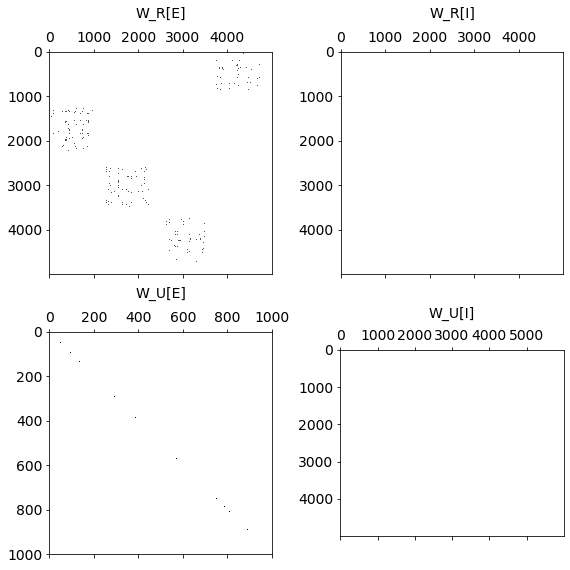

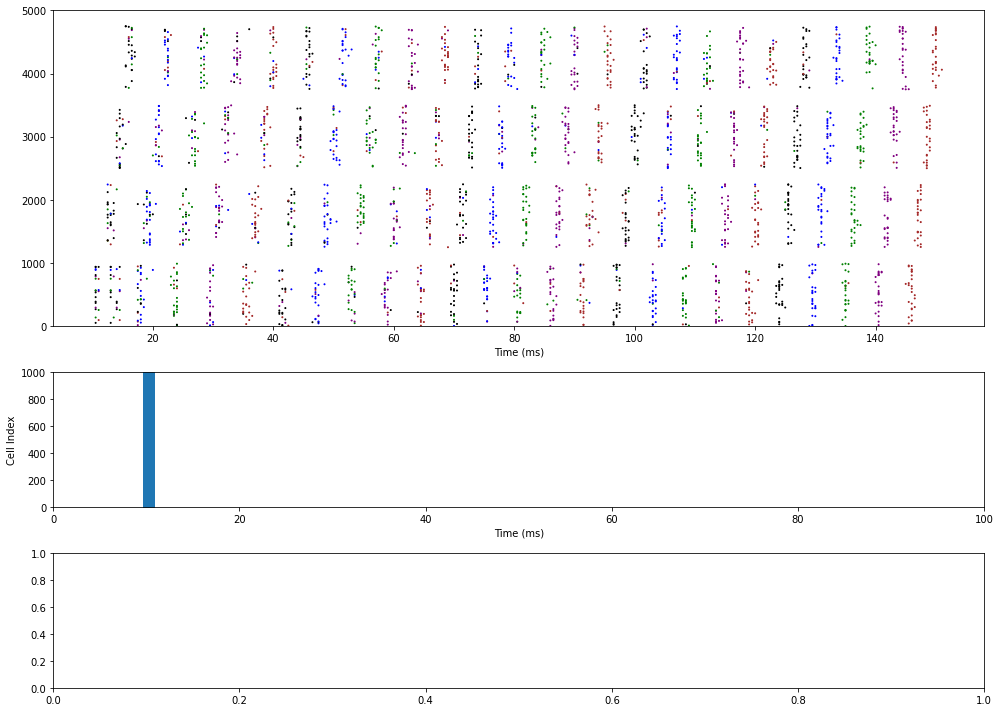

In [191]:
quick_plot(m, show_connectivity=True, n_show_only=10)

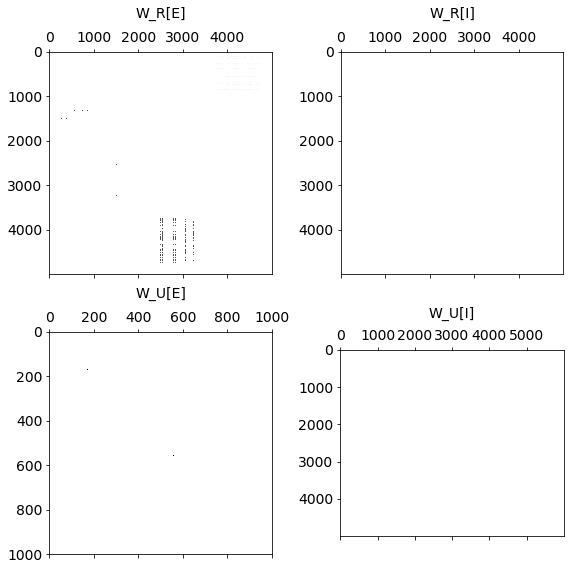

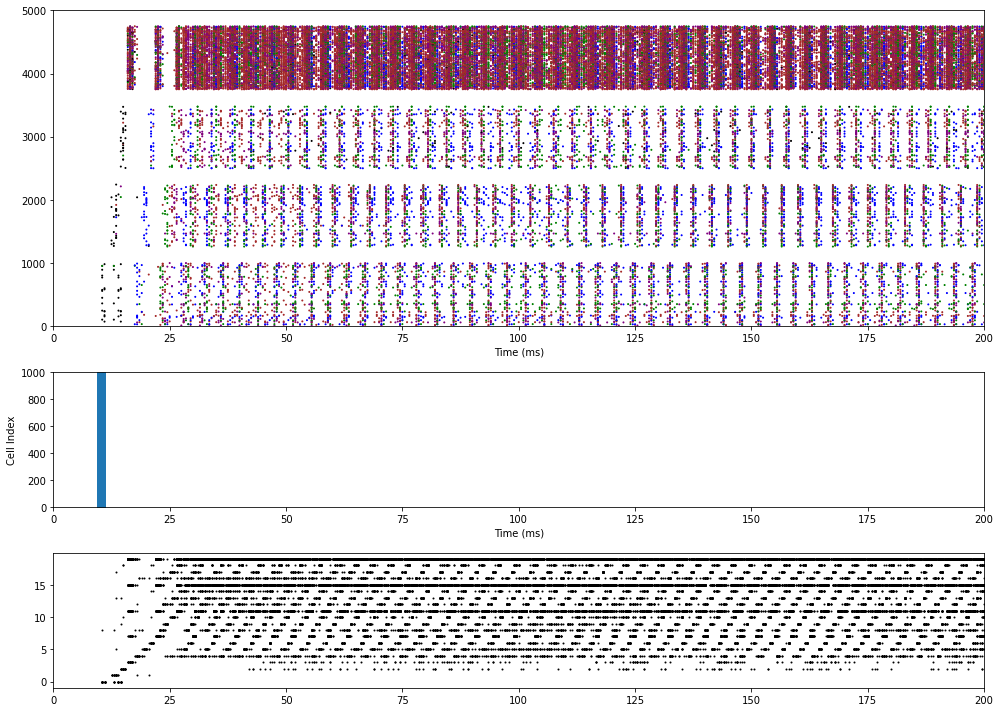

In [183]:
m2 = copy(m)
m2.F_GROUP = [0.0273, 0.0273, 0.0273, 0.5]
m2.N_LOOPS = 5
set_dynamic_vars(m2)
quick_plot(m2, show_connectivity=True, n_show_only=10)